# IMPORTS

In [1]:
import scipy.signal.signaltools
import numpy as np


def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]


import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt

from tft_helper import *

import os
import sys



basepath = os.path.abspath("")  # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta

c:\Users\nvegamun\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## TRADING ENV

In [ ]:
class TradingEnv(Env):

    def __init__(self, data, perc_to_inv=0.1, initial_balance=10000):
        # Dataset y parámetros iniciales
        self.data = data
        self.perc_to_inv = perc_to_inv
        self.initial_balance = initial_balance

        # Espacios de acción: 0 = Mantener, 1 = Comprar, 2 = Vender
        self.action_space = Discrete(3)

        # Espacios de observación: Estado del mercado (excluyendo columnas irrelevantes)
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1],), dtype=np.float32
        )

        # Variables internas
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0  # Número de acciones compradas
        self.current_step = 0
        self.done = False

        return self._get_observation()

    def step(self, action):
        # Guardar estado inicial
        prev_balance = self.balance  # Dinero disponible antes de la acción.
        prev_position_value = (
            self.position * self.data["target"].iloc[self.current_step]
        )  # Valor de las acciones poseídas al precio actual.
        prev_portfolio_value = (
            prev_balance + prev_position_value
        )  # Suma del balance y el valor de las acciones

        # Ejecutar acción
        current_price = self.data["target"].iloc[self.current_step]
        if action == 1:  # Comprar
            amount_to_buy = min(self.balance, self.perc_to_inv * self.balance)
            self.position += amount_to_buy / current_price
            self.balance -= amount_to_buy
        elif action == 2:  # Vender
            amount_to_sell = min(self.position, self.perc_to_inv * self.position)
            self.balance += amount_to_sell * current_price
            self.position -= amount_to_sell

        # Calcular recompensa
        position_value = self.position * current_price
        portfolio_value = self.balance + position_value
        # reward = portfolio_value - prev_portfolio_value
        reward = (portfolio_value - prev_portfolio_value) / (prev_portfolio_value + 1e-8)

        # Actualizar estado
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_observation(), reward, self.done, {}

    def _get_observation(self):
        # Retorna el estado actual (excluye columnas no relevantes)
        obs = self.data.iloc[self.current_step]
        # obs = (obs - obs.mean()) / (obs.std() + 1e-8)
        return obs.values.astype(np.float32)

# PARAMS

In [3]:
target_file = "BTC"
exog_files = [
    "Nasdaq",
    "IBEX35",
    "EUStoxx50",
    "DowJones",
    "S&P500",
    "USD_EUR",
    "GBP_USD",
    "USTech100",
    "S&P500Futures",
]

In [4]:
# Set ts date range
date_start = "2010-01-04"  # None #"2023-06-01"
date_end = "2024-7-29"
shift = 1  # How many times to shift values. Useful for using last indicator values (RSI, MACD...) for inference
ts_indicator_params = {
    "moving_average_windows": [5, 10, 20, 50, 100, 200],  # Moving averages periods
    # "sigma_gaussian_filter": [1, 2],
    "n_lags": 10,
}

perc_to_inv = 0.1

PIB_relevant_countries = [
    "USA",
    "CHN",
    #  'EMU',
    "DEU",
    #  'FRA',
    #  'GBR',
    "JPN",
    "IND",
    "BRA",
    "CAN",
    #  'AUS',
    #  'ITA',
    #  'KOR',
    #  'MEX',
    #  'IDN',
    #  'SAU',
    #  'ZAF',
    #  'TUR',
    #  'ESP'
]

# LOAD DATA

In [5]:
df = create_combined_ts_df(target_file, exog_files)
df

Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.


,Date,target,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,exog_S&P500,exog_USD_EUR,exog_GBP_USD,exog_USTech100,exog_S&P500Futures
0,2016-01-01,434.0,430.0,438.0,425.9,0.94,NaN,NaN,NaN,NaN,NaN,0.9208,1.4748,NaN,NaN
1,2016-01-02,433.7,434.0,437.4,430.7,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,430.7,433.7,434.1,423.1,-0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,2012.7,0.9232,1.4718,4497.9,2009.00
4,2016-01-05,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,2016.7,0.9304,1.4672,4484.2,2011.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,2024-11-20,94303.9,92252.6,94836.1,91517.4,2.24,NaN,NaN,NaN,43225.79,NaN,0.9483,1.2650,20664.8,5937.75
3247,2024-11-21,98374.5,94308.7,98937.2,94063.8,4.32,NaN,NaN,NaN,NaN,NaN,0.9546,1.2586,20695.6,5970.50
3248,2024-11-22,98929.7,98381.2,99617.4,97182.2,0.56,NaN,NaN,NaN,NaN,NaN,0.9595,1.2531,20800.4,5987.00
3249,2024-11-23,97699.0,98927.2,98927.2,97180.9,-1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = add_global_indicators(df, PIB_relevant_countries, date_start, date_end)
df = add_indicators(df, ts_indicator_params, categorical_tendency_vars=True)
# df = df.rename(columns={"target": "target_close"})
# df = df.rename(columns={"target_smoothed_2": "target"})

c:\Users\nvegamun\OneDrive - NTT DATA EMEAL\Documentos\QuantTrader-TFT\tft_helper.py:1082: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


In [7]:
# # SHift indicator values
# cols_to_shift = [
#     col for col in df.columns[3:] if not (col.startswith("AAII") or col.startswith("PIB"))
# ]
# df[cols_to_shift] = df[cols_to_shift].shift(shift)

In [8]:
rest = [
    "Date",
    "target",
    "FEDFUNDS",
    "open",
    "max",
    "min",
    "var",
    "MACD",
    "Signal_Line",
    "group",
    "month",
    "day_of_year",
    "weekday",
    "is_holiday",
    "time_idx",
]
PIB_cols = [col for col in df.columns if col.startswith("PIB")]
AAII_cols = [col for col in df.columns if col.startswith("AAII")]
VIX_cols = [col for col in df.columns if col.endswith("VIX")]
SMA_cols = [col for col in df.columns if col.startswith("SMA")]
EMA_cols = [col for col in df.columns if col.startswith("EMA")]
lag_cols = [col for col in df.columns if col.startswith("target_lag")]
target_smoothed_cols = [col for col in df.columns if col.startswith("target_smoothed")]
RSI_cols = [col for col in df.columns if col.startswith("RSI")]
Bollinger_cols = [col for col in df.columns if col.startswith("Bollinger")]
ATR_cols = [col for col in df.columns if col.startswith("ATR")]
CCI_cols = [col for col in df.columns if col.startswith("CCI")]
ROC_cols = [col for col in df.columns if col.startswith("ROC")]
Williams_cols = [col for col in df.columns if col.startswith("Williams")]
Stochastic_cols = [col for col in df.columns if col.startswith("Stochastic")]
bullish_cols = [col for col in df.columns if col.startswith("bullish")]
bearish_cols = [col for col in df.columns if col.startswith("bearish")]
exog_ts = [col for col in df.columns if col.startswith("exog")]
cols_to_convert = (
    ["target", "open", "max", "min", "var", "MACD", "Signal_Line"]
    + SMA_cols
    + EMA_cols
    + Bollinger_cols
    + ATR_cols
    + CCI_cols
    + ROC_cols
    + Williams_cols
    + Stochastic_cols
    + exog_ts
    + VIX_cols
    + lag_cols
    + target_smoothed_cols
    + RSI_cols
)
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")

In [9]:
df = df.ffill().bfill()
df = df.dropna()

In [10]:

df.drop(columns=['Date'], inplace=True)
df

,target,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,exog_S&P500,...,bullish_rsi,bearish_rsi,bullish_bollinger,bearish_bollinger,bullish_macd,bearish_macd,bullish_atr,bearish_atr,bullish_trend,bearish_trend
0,434.0,430.0,438.0,425.9,0.94,4497.86,9313.2,3164.76,17148.94,2012.70,...,0,0,0,0,0,0,0,0,0,0
1,433.7,434.0,437.4,430.7,-0.06,4497.86,9313.2,3164.76,17148.94,2012.70,...,0,0,0,0,0,1,0,0,0,0
2,430.7,433.7,434.1,423.1,-0.70,4497.86,9313.2,3164.76,17148.94,2012.70,...,0,0,0,0,0,1,0,0,0,0
3,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,2012.70,...,0,0,0,0,0,1,0,0,0,0
4,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,2016.70,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,65799.3,65363.9,66088.6,63500.9,0.66,18830.59,11145.6,4811.28,39935.07,5399.22,...,0,1,0,0,1,0,0,1,0,0
3129,67908.6,65799.7,68205.0,65764.3,3.21,19023.66,11165.9,4862.50,40589.34,5459.10,...,0,1,0,0,1,0,1,0,1,0
3130,67843.1,67910.8,69387.6,66776.8,-0.10,19023.66,11165.9,4862.50,40589.34,5459.10,...,0,1,0,0,1,0,0,1,0,0
3131,68256.3,67888.9,68291.9,67067.8,0.61,19023.66,11165.9,4862.50,40589.34,5459.10,...,0,1,0,0,1,0,0,1,0,0


In [11]:
# df.to_csv('BTC.csv', index=False)

## DATA SPLIT

In [12]:
# Dividir datos en entrenamiento y prueba
split_index = int(len(df) * 0.8)
train_data = df[:split_index]
test_data = df[split_index:]

# TRAIN

 rollout/
- **ep_len_mean**: Longitud promedio de los episodios. Un episodio termina cuando se alcanza el final del conjunto de datos o un criterio definido en el entorno. Aquí, se muestra 1.71e+03 (aproximadamente 1710 pasos), lo que indica que los episodios son largos.
- **ep_rew_mean**: Recompensa promedio por episodio. Un valor de 0 aquí indica que las recompensas proporcionadas no están incentivando al modelo de manera efectiva.

 time/
- **fps**: Pasos por segundo procesados durante el entrenamiento.
- **iterations**: Número de iteraciones completadas.
- **time_elapsed**: Tiempo total transcurrido durante el entrenamiento.
- **total_timesteps**: Número total de pasos de entrenamiento procesados.

 train/
- **approx_kl**: Aproximación al KL-divergence. Un valor bajo indica que las políticas no están cambiando demasiado rápido, lo cual es deseable.
- **clip_fraction**: Fracción de las acciones que excedieron el rango permitido por la política de clipping. Un valor bajo es ideal.
- **entropy_loss**: Representa la incertidumbre de las acciones. Valores más altos indican más exploración, mientras que valores bajos indican más confianza en las políticas aprendidas.
- **explained_variance**: Qué tan bien la red de valor predice las recompensas futuras. Un valor cercano a 1 indica una buena predicción, mientras que valores cercanos a 0 indican problemas.
- **loss**: La pérdida total que se optimiza. Puede incluir la pérdida de la política y el valor.
- **policy_gradient_loss**: Pérdida relacionada con las acciones tomadas por la política.


In [13]:
# Crear entorno de entrenamiento
env = make_vec_env(lambda: TradingEnv(train_data), n_envs=1)

# Configurar y entrenar el modelo
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000)

# Guardar el modelo
# model.save("trading_bot_model")

c:\Users\nvegamun\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1335 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


# EVAL

In [14]:
# Evaluar en el conjunto de prueba
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()
total_reward = 0
actions = []
while True:
    action, _states = model.predict(eval_obs)
    actions.append(action)
    eval_obs, reward, done, _ = eval_env.step(action)
    total_reward += reward
    if done:
        break
print("Acciones tomadas:", actions)


print("Recompensa total en el conjunto de prueba:", total_reward)

Acciones tomadas: [array(2, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(0, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(1, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(1, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(1, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array(1, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=int64), array(0, dtype=

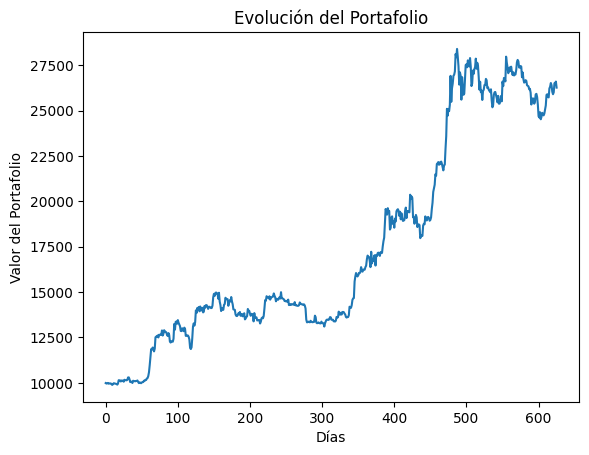

In [15]:
import matplotlib.pyplot as plt

portfolio_values = []
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()

while True:
    action, _states = model.predict(eval_obs)
    eval_obs, reward, done, _ = eval_env.step(action)
    portfolio_values.append(
        eval_env.balance + eval_env.position * eval_env.data["target"].iloc[eval_env.current_step]
    )
    if done:
        break

plt.plot(portfolio_values)
plt.title("Evolución del Portafolio")
plt.xlabel("Días")
plt.ylabel("Valor del Portafolio")
plt.show()

In [16]:
# Evaluar rentabilidad acumulada
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()
portfolio_values = []

while True:
    action, _states = model.predict(eval_obs)
    eval_obs, reward, done, _ = eval_env.step(action)
    portfolio_values.append(
        eval_env.balance + eval_env.position * eval_env.data["target"].iloc[eval_env.current_step]
    )
    if done:
        break

initial_value = portfolio_values[0]
final_value = portfolio_values[-1]
cumulative_return = (final_value / initial_value) - 1

print("Rentabilidad acumulada:", cumulative_return)

Rentabilidad acumulada: 1.4119336175496047


In [17]:
# Ratio de Sharpe: Relación entre la rentabilidad y el riesgo asumido. Valores superiores a 1 son aceptables; valores superiores a 2 son excelentes.
import numpy as np

returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Retornos diarios
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # 252 días de mercado al año
print("Sharpe Ratio:", sharpe_ratio)

# Drawdown máximo: La mayor caída desde un pico histórico del portafolio. Evalúa el riesgo.
drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)
max_drawdown = drawdown / np.maximum.accumulate(portfolio_values).max()
print("Máximo Drawdown:", max_drawdown)

Sharpe Ratio: 1.6398969213746055
Máximo Drawdown: 0.16363615129671083
